In [2]:
pip install fyers-apiv3 pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.9.0
    Uninstalling websocket-client-1.9.0:
      Successfully uninstalled websocket-client-1.9.0
  Attempting unin

**1. Data Acquisition**

In [105]:
import pandas as pd
from fyers_apiv3 import fyersModel
import os

CLIENT_ID = "QVVDKYBQMQ-100"
ACCESS_TOKEN = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCcFpKaFpQSkszYi1MR1RESmhpbkV2VUg5M2F2d3hoU251MUJSSHBUSWRGYThqc2pfRGs1RDJFVmdqb0dXR1RnUEhBRGZCb0l1NTBPTTg3QTFJckNZSm5hemxIclFtZjE3Y2s4aEl6Snl6MnRjTlRNST0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxZDFhOTRjYjQzNjM2M2ZiY2ZhNzkyNDNjMmViZTAzYjMzYWI4YTY2YTc2ZDkxMGM5YmM3MTFjNiIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFIODkxMjciLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc2ODI2NDIwMCwiaWF0IjoxNzY4MjAwMjgxLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NjgyMDAyODEsInN1YiI6ImFjY2Vzc190b2tlbiJ9.oYNs5FrlMBjOtDDQ3ZwKnBnr-ERlDnnPj0xaBlCVFKs"
STOCKS = ["SONATSOFTW", "IRCON", "RITES"]
START_DATE = "2025-11-01"
END_DATE = "2025-12-31"

class FyersDataDownloader:
    def __init__(self, client_id, access_token):
        self.fyers = fyersModel.FyersModel(client_id=client_id, token=access_token, log_path="")
        if not os.path.exists('data'):
            os.makedirs('data')

    def fetch_ohlcv(self, symbol, start, end):
        request_params = {
            "symbol": f"NSE:{symbol}-EQ",
            "resolution": "D",
            "date_format": "1",
            "range_from": start,
            "range_to": end,
            "cont_flag": "1"
        }

        response = self.fyers.history(data=request_params)

        if response.get("s") == "ok":
            df = pd.DataFrame(response.get("candles"),
                              columns=['date', 'open', 'high', 'low', 'close', 'volume'])

            df['date'] = pd.to_datetime(df['date'], unit='s')
            df['date'] = df['date'].dt.tz_localize('UTC').dt.tz_convert('Asia/Kolkata').dt.tz_localize(None)

            return df
        else:
            print(f"Failed to fetch {symbol}: {response.get('message')}")
            return None

if __name__ == "__main__":
    downloader = FyersDataDownloader(CLIENT_ID, ACCESS_TOKEN)

    for ticker in STOCKS:
        data = downloader.fetch_ohlcv(ticker, START_DATE, END_DATE)
        if data is not None:
            output_path = f"data/{ticker}_historical.csv"
            data.to_csv(output_path, index=False)
            print(f"Data for {ticker} saved to {output_path}")

Data for SONATSOFTW saved to data/SONATSOFTW_historical.csv
Data for IRCON saved to data/IRCON_historical.csv
Data for RITES saved to data/RITES_historical.csv


**2. Feature Engineering & Spearman Selection**

In [145]:
import pandas as pd
import numpy as np
import os

BASE_PATH = "/content/data"
STOCKS = ["IRCON", "RITES", "SONATSOFTW"]

def generate_ready_data(symbol):
    file_path = f"{BASE_PATH}/{symbol}_historical.csv"

    if not os.path.exists(file_path):
        print(f"Skipping {symbol}: File not found.")
        return

    df = pd.read_csv(file_path)

    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
    df['feat_momentum'] = df['log_ret'].rolling(5).sum()
    df['feat_ret_zscore'] = (df['log_ret'] - df['log_ret'].rolling(20).mean()) / df['log_ret'].rolling(20).std()

    park_factor = 1 / (4 * np.log(2))
    df['park_sq'] = park_factor * (np.log(df['high'] / df['low'])**2)
    df['feat_parkinson'] = np.sqrt(df['park_sq'].rolling(5).mean())

    df['feat_ewma_vol'] = df['log_ret'].pow(2).ewm(alpha=0.06, adjust=False).mean().apply(np.sqrt)
    df['feat_vol_innov'] = (df['log_ret']**2) - df['feat_ewma_vol'].shift(1)
    df['feat_rv_5d'] = df['log_ret'].rolling(5).std() * np.sqrt(252)

    df['feat_volu_z'] = (df['volume'] - df['volume'].rolling(10).mean()) / df['volume'].rolling(10).std()

    df['target'] = (df['log_ret'].shift(-1) > 0).astype(int)

    df.dropna(inplace=True)

    feat_cols = [c for c in df.columns if c.startswith('feat_')]
    corr_matrix = df[feat_cols].corr(method='spearman').abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

    df_final = df.drop(columns=to_drop)

    save_path = f"{BASE_PATH}/{symbol}_ready.csv"
    df_final.to_csv(save_path, index=False)

    print(f"Processed {symbol}: {len(df_final)} rows. Dropped redundant: {to_drop}")
    return df_final

if __name__ == "__main__":
    for ticker in STOCKS:
        generate_ready_data(ticker)

Processed IRCON: 21 rows. Dropped redundant: ['feat_parkinson', 'feat_ewma_vol', 'feat_vol_innov', 'feat_rv_5d']
Processed RITES: 21 rows. Dropped redundant: ['feat_ewma_vol', 'feat_vol_innov', 'feat_rv_5d']
Processed SONATSOFTW: 21 rows. Dropped redundant: ['feat_ewma_vol', 'feat_rv_5d']


 **3.Correlation analysis**

In [108]:
import pandas as pd
import numpy as np

def compute_extended_features(df):
    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))

    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['feat_rsi'] = 100 - (100 / (1 + rs))

    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    df['feat_macd'] = exp1 - exp2

    sma = df['close'].rolling(window=20).mean()
    std = df['close'].rolling(window=20).std()
    df['feat_bb_width'] = (4 * std) / sma

    park_factor = 1 / (4 * np.log(2))
    df['feat_parkinson'] = np.sqrt(park_factor * (np.log(df['high'] / df['low'])**2).rolling(5).mean())

    df['feat_ewma_vol'] = df['log_ret'].pow(2).ewm(alpha=0.06, adjust=False).mean().apply(np.sqrt)

    return df.dropna()

if __name__ == "__main__":
    filepath = 'data/SONATSOFTW_historical.csv'

    try:
        df_raw = pd.read_csv(filepath)
        df_processed = compute_extended_features(df_raw)

        feature_cols = [col for col in df_processed.columns if 'feat_' in col]
        correlation_matrix = df_processed[feature_cols].corr(method='spearman')

        print(f"Feature Analysis for {filepath}:")
        print(correlation_matrix.round(2))

    except FileNotFoundError:
        print(f"Error: Could not find {filepath}. Ensure your data download script has run.")

Feature Analysis for data/SONATSOFTW_historical.csv:
                feat_rsi  feat_macd  feat_bb_width  feat_parkinson  \
feat_rsi            1.00       0.59          -0.14            0.24   
feat_macd           0.59       1.00           0.56            0.74   
feat_bb_width      -0.14       0.56           1.00            0.60   
feat_parkinson      0.24       0.74           0.60            1.00   
feat_ewma_vol       0.10       0.62           0.63            0.92   

                feat_ewma_vol  
feat_rsi                 0.10  
feat_macd                0.62  
feat_bb_width            0.63  
feat_parkinson           0.92  
feat_ewma_vol            1.00  


**4. Bayesian Ridge Strategy**

In [144]:
import pandas as pd
import numpy as np
from fyers_apiv3 import fyersModel
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler

CLIENT_ID = "QVVDKYBQMQ-100"
ACCESS_TOKEN = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCcFpMeHpnS1JtVXphN3ZiaTV5ZS01MWRwOWd6bHNuakw2aktmcmpmZWlIalZUS1Bkel9oQ0NzckZSZGEtX3pRSzR0d0pwbEZFS3ExdFk1LUZGNzlQVVBmanVrX19kTk9uWV9MaTRsTklVcFFFN0FIRT0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxZDFhOTRjYjQzNjM2M2ZiY2ZhNzkyNDNjMmViZTAzYjMzYWI4YTY2YTc2ZDkxMGM5YmM3MTFjNiIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFIODkxMjciLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc2ODI2NDIwMCwiaWF0IjoxNzY4MjA5NTIzLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NjgyMDk1MjMsInN1YiI6ImFjY2Vzc190b2tlbiJ9.kbICUYGTGSSRlP_0tec6FkrJ4uSp6zPLmUVtJslK4gc"
SYMBOL = "NSE:RITES-EQ"
INITIAL_CAPITAL = 100000

MAX_EXPOSURE_PCT = 0.5     # exposure level
TARGET_VOL = 0.012         # 1.2% Daily risk target
SLIPPAGE = 0.0010          # Standard 10 bps friction (Brokerage + Tax + Spread)

fyers = fyersModel.FyersModel(client_id=CLIENT_ID, token=ACCESS_TOKEN)

def run_bayesian_strategy():
    query = {
        "symbol": SYMBOL, "resolution": "D", "date_format": "1",
        "range_from": "2025-11-01", "range_to": "2026-01-08", "cont_flag": "1"
    }
    response = fyers.history(data=query)
    if "candles" not in response: return print(" API Error")

    df = pd.DataFrame(response['candles'], columns=['date','open','high','low','close','volume'])
    df['date'] = pd.to_datetime(df['date'], unit='s')

    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
    df['vol_5d'] = df['log_ret'].rolling(5).std().shift(1)
    df['mom_5d'] = df['log_ret'].rolling(5).sum().shift(1)

    df['long_ret'] = np.log(df['close'] / df['open'])
    df['short_ret'] = np.log(df['open'] / df['close']) # Profit if price drops

    df = df.dropna().reset_index(drop=True)
    features = ['mom_5d', 'vol_5d']
    capital = INITIAL_CAPITAL
    results = []

    test_start_date = pd.Timestamp('2026-01-01')

    for i in range(len(df)):
        current_date = df.loc[i, 'date']
        if current_date < test_start_date:
            continue

        train_df = df.iloc[:i]
        today_row = df.iloc[i:i+1]

        scaler = StandardScaler().fit(train_df[features])
        X_train = scaler.transform(train_df[features])
        y_train = train_df['log_ret']

        model = BayesianRidge()
        model.fit(X_train, y_train)

        X_today = scaler.transform(today_row[features])
        pred_mu, pred_std = model.predict(X_today, return_std=True)

        p_mu, p_std = float(pred_mu[0]), float(pred_std[0])
        signal_ir = p_mu / p_std

        # We require signal to be > 0.03 or 50% of historical average IR strength
        hist_ir_avg = abs(train_df['log_ret'].mean() / train_df['log_ret'].std())
        dynamic_threshold = max(0.03, hist_ir_avg * 0.5)

        # Volatility-Adjusted Position Sizing
        hist_vol = float(train_df['log_ret'].std())

        conf_multiplier = 1.0 if p_std < (1.2 * hist_vol) else 0.5
        vol_ratio = min(TARGET_VOL / (hist_vol + 1e-8), 1.0)
        pos_size = capital * MAX_EXPOSURE_PCT * vol_ratio * conf_multiplier

        side, pnl = "CASH", 0
        if signal_ir > dynamic_threshold:
            side = "BUY"
            pnl = (float(today_row['long_ret'].values[0]) * pos_size) - (SLIPPAGE * pos_size)
        elif signal_ir < -dynamic_threshold:
            side = "SHORT"
            pnl = (float(today_row['short_ret'].values[0]) * pos_size) - (SLIPPAGE * pos_size)

        capital += pnl
        results.append({
            "Date": current_date.date(), "Side": side, "Position": round(pos_size, 2),
            "PnL": round(pnl, 2), "Equity": round(capital, 2), "IR": round(signal_ir, 4)
        })

    res_df = pd.DataFrame(results)
    res_df['Daily_Pct'] = res_df['PnL'] / INITIAL_CAPITAL
    sharpe = np.sqrt(252) * res_df['Daily_Pct'].mean() / (res_df['Daily_Pct'].std() + 1e-10)

    print(f"\n REPORT: {SYMBOL} ")
    print(res_df[['Date', 'Side', 'PnL', 'Equity', 'IR']])
    print("-" * 50)
    print(f" Net Strategy PnL: ₹{capital - INITIAL_CAPITAL:.2f}")
    print(f"Annualized Sharpe Ratio: {sharpe:.2f}")

if __name__ == "__main__":
    run_bayesian_strategy()


 REPORT: NSE:RITES-EQ 
         Date   Side     PnL     Equity      IR
0  2026-01-01    BUY    0.88  100000.88  0.0608
1  2026-01-02    BUY  302.91  100303.79  0.0543
2  2026-01-05    BUY -269.05  100034.74  0.0473
3  2026-01-06   CASH    0.00  100034.74  0.0032
4  2026-01-07  SHORT -199.88   99834.87 -0.0594
5  2026-01-08  SHORT  729.61  100564.48 -0.0859
--------------------------------------------------
 Net Strategy PnL: ₹564.48
Annualized Sharpe Ratio: 4.04


5.**Comparison with buy and hold**


--- PERFORMANCE SUMMARY ---
         Date   Side      IR  Strategy_Equity  Benchmark_Equity
0  2026-01-01    BUY  0.0608    100001.320852     100181.211647
1  2026-01-02    BUY  0.0543    100455.690242     101264.363082
2  2026-01-05    BUY  0.0473    100051.506130     100728.965034
3  2026-01-06   CASH  0.0032    100051.506130      99884.683497
4  2026-01-07  SHORT -0.0594     99751.642628      99971.170874
5  2026-01-08  SHORT -0.0859    100845.152034      97446.563156

 Final Strategy: ₹100845.15
 Final Benchmark: ₹97446.56
 Net Alpha: ₹3398.59


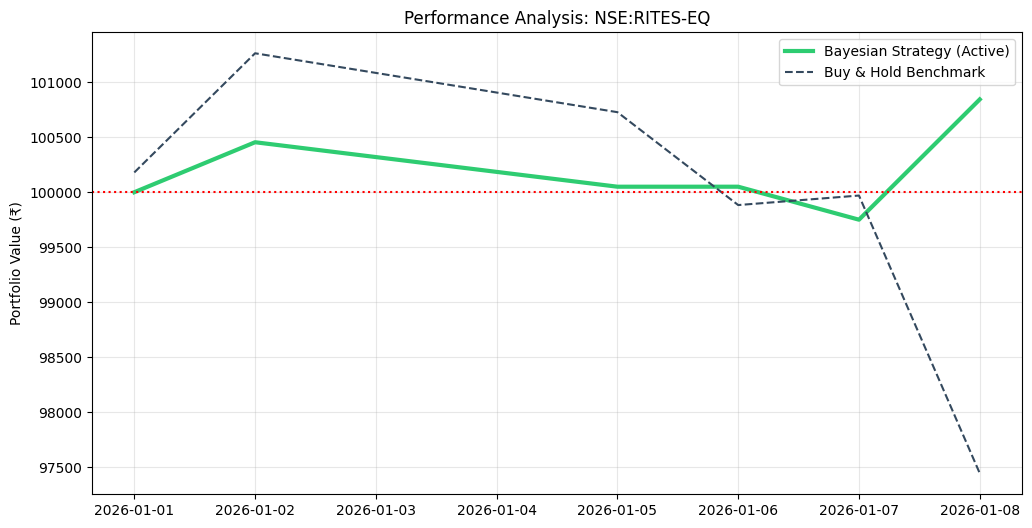

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fyers_apiv3 import fyersModel
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler

CLIENT_ID = "QVVDKYBQMQ-100"
ACCESS_TOKEN = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCcFpMeHpnS1JtVXphN3ZiaTV5ZS01MWRwOWd6bHNuakw2aktmcmpmZWlIalZUS1Bkel9oQ0NzckZSZGEtX3pRSzR0d0pwbEZFS3ExdFk1LUZGNzlQVVBmanVrX19kTk9uWV9MaTRsTklVcFFFN0FIRT0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxZDFhOTRjYjQzNjM2M2ZiY2ZhNzkyNDNjMmViZTAzYjMzYWI4YTY2YTc2ZDkxMGM5YmM3MTFjNiIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFIODkxMjciLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc2ODI2NDIwMCwiaWF0IjoxNzY4MjA5NTIzLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NjgyMDk1MjMsInN1YiI6ImFjY2Vzc190b2tlbiJ9.kbICUYGTGSSRlP_0tec6FkrJ4uSp6zPLmUVtJslK4gc"
SYMBOL = "NSE:RITES-EQ"
INITIAL_CAPITAL = 100000
MAX_EXPOSURE_PCT = 0.75
TARGET_VOL = 0.012
SLIPPAGE = 0.0010

fyers = fyersModel.FyersModel(client_id=CLIENT_ID, token=ACCESS_TOKEN)

def run_comparative_strategy():
    query = {
        "symbol": SYMBOL, "resolution": "D", "date_format": "1",
        "range_from": "2025-11-01", "range_to": "2026-01-08", "cont_flag": "1"
    }
    response = fyers.history(data=query)

    if "candles" not in response or not response['candles']:
        print(" Error: API response is empty.")
        return None

    df = pd.DataFrame(response['candles'], columns=['date','open','high','low','close','volume'])
    df['date'] = pd.to_datetime(df['date'], unit='s')

    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
    df['vol_5d'] = df['log_ret'].rolling(5).std().shift(1)
    df['mom_5d'] = df['log_ret'].rolling(5).sum().shift(1)
    df['intraday_ret'] = np.log(df['close'] / df['open'])
    df['short_ret'] = np.log(df['open'] / df['close'])

    df = df.dropna().reset_index(drop=True)
    features = ['mom_5d', 'vol_5d']

    strat_cap = INITIAL_CAPITAL
    results = []
    test_start = pd.Timestamp('2026-01-01')

    for i in range(len(df)):
        curr_date = df.loc[i, 'date']
        if curr_date < test_start:
            continue

        train = df.iloc[:i]
        today = df.iloc[i:i+1]

        scaler = StandardScaler().fit(train[features])
        X_train = scaler.transform(train[features])
        y_train = train['log_ret']
        model = BayesianRidge().fit(X_train, y_train)

        X_today = scaler.transform(today[features])
        mu, std = model.predict(X_today, return_std=True)
        signal_ir = float(mu[0] / std[0])

        hist_ir = abs(train['log_ret'].mean() / (train['log_ret'].std() + 1e-9))
        thresh = max(0.03, hist_ir * 0.5)

        h_vol = float(train['log_ret'].std())
        vol_scale = min(TARGET_VOL / (h_vol + 1e-9), 1.0)
        pos = strat_cap * MAX_EXPOSURE_PCT * vol_scale

        pnl = 0
        side = "CASH"

        if signal_ir > thresh:
            side = "BUY"
            pnl = (float(today['intraday_ret'].values[0]) * pos) - (SLIPPAGE * pos)
        elif signal_ir < -thresh:
            side = "SHORT"
            pnl = (float(today['short_ret'].values[0]) * pos) - (SLIPPAGE * pos)

        strat_cap += pnl
        bench_ret = float(today['log_ret'].values[0])

        results.append({
            "Date": curr_date.date(),
            "Side": side,
            "Strategy_Equity": strat_cap,
            "Bench_Log_Ret": bench_ret,
            "IR": round(signal_ir, 4)
        })

    res_df = pd.DataFrame(results)
    res_df['Benchmark_Equity'] = INITIAL_CAPITAL * np.exp(res_df['Bench_Log_Ret'].cumsum())

    return res_df

res = run_comparative_strategy()

if res is not None:
    print("\n--- PERFORMANCE SUMMARY ---")
    print(res[['Date', 'Side', 'IR', 'Strategy_Equity', 'Benchmark_Equity']])

    strat_final = res['Strategy_Equity'].iloc[-1]
    bench_final = res['Benchmark_Equity'].iloc[-1]
    print(f"\n Final Strategy: ₹{strat_final:.2f}")
    print(f" Final Benchmark: ₹{bench_final:.2f}")
    print(f" Net Alpha: ₹{strat_final - bench_final:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(res['Date'], res['Strategy_Equity'], label='Bayesian Strategy (Active)', color='#2ecc71', lw=3)
    plt.plot(res['Date'], res['Benchmark_Equity'], label='Buy & Hold Benchmark', color='#34495e', ls='--')
    plt.axhline(y=INITIAL_CAPITAL, color='red', ls=':')
    plt.title(f"Performance Analysis: {SYMBOL}")
    plt.ylabel("Portfolio Value (₹)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()